In [8]:
import pandas as pd
import numpy as np
import os # doesnt have to be installed with pip

import seaborn as sns

In [2]:
# Checking the dimensions of the tables, same columns, same number of rows?
directory = 'data/'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_directory = os.path.join(directory, filename)
        df = pd.read_csv(file_directory)
        print(file_directory)
        print(df.shape)

data/Kickstarter040.csv
(3779, 37)
data/Kickstarter054.csv
(3793, 37)
data/Kickstarter055.csv
(965, 37)
data/Kickstarter041.csv
(3792, 37)
data/Kickstarter043.csv
(3790, 37)
data/Kickstarter042.csv
(3786, 37)
data/Kickstarter052.csv
(3791, 37)
data/Kickstarter046.csv
(3786, 37)
data/Kickstarter047.csv
(3788, 37)
data/Kickstarter053.csv
(3787, 37)
data/Kickstarter045.csv
(3787, 37)
data/Kickstarter051.csv
(3780, 37)
data/Kickstarter050.csv
(3789, 37)
data/Kickstarter044.csv
(3779, 37)
data/Kickstarter023.csv
(3780, 37)
data/Kickstarter037.csv
(3793, 37)
data/Kickstarter036.csv
(3784, 37)
data/Kickstarter022.csv
(3778, 37)
data/Kickstarter008.csv
(3784, 37)
data/Kickstarter034.csv
(3784, 37)
data/Kickstarter020.csv
(3786, 37)
data/Kickstarter021.csv
(3787, 37)
data/Kickstarter035.csv
(3794, 37)
data/Kickstarter009.csv
(3790, 37)
data/Kickstarter031.csv
(3787, 37)
data/Kickstarter025.csv
(3784, 37)
data/Kickstarter019.csv
(3791, 37)
data/Kickstarter018.csv
(3785, 37)
data/Kickstarter024.c

In [3]:
def mult_csv_to_one_df(directory: str, axis=0):
    '''
    Searches a directory (absolute or relative path) for csv files (they need to have the csv ending, comma as delimiter).
    Returns a dataframe of concatenated tables. Axis as in Pandas.
    Dependencies: pandas and os
    '''
    first = True
    for filename in os.listdir(directory):
        if first == True:
            first = False
            df = pd.read_csv(os.path.join(directory, filename))
        else:
            if filename.endswith(".csv"):
                file_directory = os.path.join(directory, filename)
                df_next = pd.read_csv(file_directory)
                df = pd.concat([df,df_next], axis=axis)
    return df

In [4]:
df = mult_csv_to_one_df('data/')

In [7]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,315,Babalus Shoes,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,True,...,babalus-childrens-shoes,https://www.kickstarter.com/discover/categorie...,False,False,live,1548223375,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",28645.000000,international
1,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,True,...,the-ofrenda-oracle-deck,https://www.kickstarter.com/discover/categorie...,True,False,successful,1504976459,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1950.000000,domestic
2,271,"Electra's long awaited, eclectic Debut Pop/Roc...","{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",22404,US,1348987533,"{""id"":323849677,""name"":""Electra"",""is_registere...",USD,$,True,...,record-electras-debut-album-pop-rock-classical,https://www.kickstarter.com/discover/categorie...,True,False,successful,1371013395,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",22404.000000,international
3,3,The Mist of Tribunal is a turn-based card game...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",165,GB,1483780271,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",GBP,£,False,...,the-mist-of-tribunal-a-card-game,https://www.kickstarter.com/discover/categorie...,False,False,failed,1489425776,1.216066,"{""web"":{""project"":""https://www.kickstarter.com...",165.384934,domestic
4,3,"Livng with a brain impairment, what its like t...","{""id"":48,""name"":""Nonfiction"",""slug"":""publishin...",2820,US,1354817071,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",USD,$,True,...,help-change-the-face-of-brain-impairment,https://www.kickstarter.com/discover/categorie...,True,False,successful,1357763527,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",2820.000000,domestic


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209222 entries, 0 to 3791
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     obj

In [15]:
df[df.friends.isnull() == False]['friends'].unique()

array(['[]'], dtype=object)

In [9]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'],
      dtype='object')

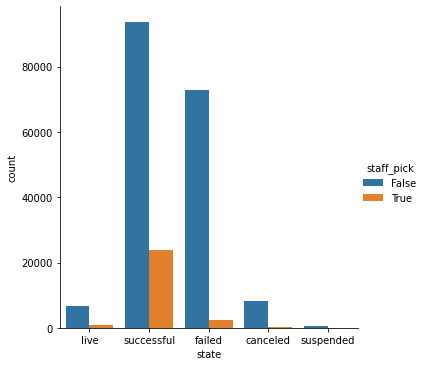

In [17]:
sns.catplot(data=df, x='state', hue='staff_pick', kind='count')